# Preparing corpus

## Load data

In [2]:
import os
import sys
import torch
import pandas as pd

drive_path = 'drive/MyDrive/Colab Notebooks/'
sys.path.insert(0, os.path.abspath(drive_path))

import conll

train_set = [sent for sent in conll.read_corpus_conll(drive_path + 'data/conll/train.txt') if '-DOCSTART-' not in sent[0][0]]
test_set = [sent for sent in conll.read_corpus_conll(drive_path + 'data/conll/test.txt') if '-DOCSTART-' not in sent[0][0]]

# reshape dataset
train_set = [[(token[0].split()[0], token[0].split()[-1]) for token in sent] for sent in train_set]
test_set = [[(token[0].split()[0], token[0].split()[-1]) for token in sent] for sent in test_set]

print(train_set[0][:4])
print(test_set[0][:4])

[('EU', 'B-ORG'), ('rejects', 'O'), ('German', 'B-MISC'), ('call', 'O')]
[('SOCCER', 'O'), ('-', 'O'), ('JAPAN', 'B-LOC'), ('GET', 'O')]


## Preparing data

### Define function to get vocabulary of words and tags (labels)

In [3]:
# idx specifies the index of the colunm to get (0: words, -1: tags)
def get_vocabulary(data, idx=0):
    vocab = set()
    for sent in data:
        for token in sent:
            vocab.add(token[idx])
    return sorted(list(vocab))

### Create numerical mappings for words and tags

In [4]:
def create_mapping(vocabulary, initial=None):
    idx = {} if initial is None else initial

    idx.update(
        {w: i + len(idx) for i, w in enumerate(vocabulary)}
        )
    return idx

In [5]:
# get vocab
words = get_vocabulary(train_set)
labels = get_vocabulary(train_set, -1)

# word mappings

# word to index
# word index
word2idx = create_mapping(words, initial={"<PAD>":0, "<UNK>":1})

# index to word, the inverse of the previous map
# allowed since indexes are unique
idx2word = {v: k for k, v in word2idx.items()}

# labels mappings

# label to index
label2idx = create_mapping(labels)

# index to label, the inverse of the previous map
# allowed since indexes are unique
idx2label = {v: k for k, v in label2idx.items()}

### Pad and truncate

In [6]:
def pad_and_truncate(sequences, max_len, value):

  for i, seq in enumerate(sequences):
    l = len(seq)
    if l > max_len:
      # truncate
      sequences[i] = seq[:max_len]
    else:
      # pad
      delta = max_len - l
      pad = [value for i in range(delta)]
      seq.extend(pad)
      sequences[i] = seq
  
  return sequences

Prepare in advance a function to unpad e change the format for CoNLL evaluation

In [40]:
def unpad(preds, truths):
  refs = truths.copy()
  if len(preds) != len(refs):
    raise ValueError
  
  pp = 0
  tt = 0

  hyps = []
  
  for i, sent in enumerate(refs):
    if len(sent) < len(preds[i]):
      # sentence has been padded
      hyps.append(preds[i][:len(sent)])
    
    elif len(sent) > len(preds[i]):
      # sentence has been truncated
      # in this case its necessary to truncate
      # also the ground truth so that they can be
      # compared
      refs[i] = refs[i][:len(preds[i])]
      hyps.append(preds[i])
    
    elif len(sent) == len(preds[i]):
      hyps.append(preds[i])

  return hyps, refs

In [8]:
def format_predictions_for_conll(preds, idx2label):
  return [[('_', idx2label.get(i)) for i in s] for s in preds]

## Define functions to prepare the dataset and the train step for later

### Train set

In [9]:
import torch.nn.functional as F

def prepare_train(train_set, labels, word2idx, label2idx, max_len=None):
  # vectorize data
  x_train_int = [[word2idx[w] for w, t in s] for s in train_set]
  # print("Train textual: {}".format(list(map(lambda x: x[0], train_set[0]))))
  # print("Train encoded: {}".format(x_train_int[0]))

  # padding and truncating

  # get max length
  if max_len is None:
    max_len = max(map(len, x_train_int))

  # pad the sentences to max length
  x_train_pad = pad_and_truncate(x_train_int, max_len, word2idx['<PAD>'])

  # vectorize labels
  y_train_int = [[label2idx[t] for w, t in s] for s in train_set]
  y_train_pad = pad_and_truncate(y_train_int, max_len, label2idx['O'])

  x_train_pad = torch.tensor(x_train_pad)
  y_train_pad = torch.tensor(y_train_pad)

  # 8 is the id of 'O'
  # print("Textual: {}".format(list(map(lambda x: x[1], train_set[0]))))
  # print("Encoded & Padded: {}".format(y_train_pad[0]))

  # one-hot encoding for labels
  y_train_ohv = F.one_hot(y_train_pad, num_classes=len(labels))

  return x_train_pad, y_train_ohv.float(), max_len

### Test Set

In [10]:
def prepare_test(test_set, labels, word2idx, label2idx, max_len):
  # replace words not in training with <UNK>
  # insert in X_test_int the index of the word if it is in the vocabulary
  # otherwise inserts the index for <UNK>
  x_test_int = [[word2idx.get(w, word2idx.get('<UNK>')) for w, t in s] for s in test_set]
  x_test_pad = pad_and_truncate(x_test_int, max_len, word2idx['<PAD>'])

  # replace tags not in training with 'O'
  # same way as before
  y_test_int = [[label2idx.get(t, label2idx.get('O')) for w, t in s] for s in test_set]
  y_test_pad = pad_and_truncate(y_test_int, max_len, label2idx['O'])

  x_test_pad = torch.tensor(x_test_pad)
  y_test_pad = torch.tensor(y_test_pad)

  # to one-hot encoding
  y_test_ohv = F.one_hot(y_test_pad, num_classes=len(labels))

  return x_test_pad, y_test_ohv.float()

## Putting all in a Dataset object

In [11]:
from torch.utils.data import TensorDataset, DataLoader

# mean_len = int(sum(map(len, train_set))/len(train_set))
# print(mean_len)

X_train, Y_train, max_len = prepare_train(train_set, labels, word2idx, label2idx)
X_test, Y_test = prepare_test(test_set, labels, word2idx, label2idx, max_len)

train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Define train step

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
def train_step(X, Y, model, loss_f, optimizer):
  model.zero_grad()

  # Get model predictions
  pred = model(X)

  # Computes loss
  loss = loss_f(pred, Y)

  # Computes gradients
  loss.backward()

  # Updates parameters and zeroes gradients
  optimizer.step()

  # Returns the loss
  return loss.item()

# Create and train a BiLSTM

## Define the model

In [14]:
import torch.nn as nn

class BiLSTM(nn.Module):
  def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size, pad_value):
    super(BiLSTM, self).__init__()

    self.hidden_dim = hidden_dim

    self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_value)

    self.dropout = nn.Dropout(0.5)

    # The LSTM takes word embeddings as inputs, and outputs hidden states
    # with dimensionality hidden_dim.
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, batch_first=True)

    # The linear layer that maps from hidden state space to tag space
    self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)

    self.softmax = nn.Softmax(dim=2)

  def forward(self, sentences):
    # INPUT: batch size (= number of sentences) x len (= number of tokens)

    # EMBEDS: # batch size x len x embedding_dim
    # B sentences composed of L tokens, one embedding for token
    embeds = self.word_embeddings(sentences)
    embeds = self.dropout(embeds)

    # LSTM_OUT: batch x len x hidden_dim * 2 (because it is bidirectional)
    lstm_out, _ = self.lstm(embeds)

    # TAG_SPACE: batch x len x tagset_size
    # for each token in each sentence Linear gives a vector of scores, one for each class/label
    tag_space = self.hidden2tag(lstm_out)

    # convert to probabilities
    tag_scores = self.softmax(tag_space)
    
    return tag_scores

In [15]:
model = BiLSTM(
    embedding_dim=64, # embedding output
    hidden_dim=64, # lstm output
    vocab_size=len(words)+2,
    tagset_size=len(labels),
    pad_value=word2idx['<PAD>']
).to(device)

model

BiLSTM(
  (word_embeddings): Embedding(23625, 64, padding_idx=0)
  (dropout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(64, 64, batch_first=True, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=9, bias=True)
  (softmax): Softmax(dim=2)
)

## Training the model

In [16]:
def train_model(model, train_dataset, bs, epochs, print_every, device):
  train_dataloader = DataLoader(
    train_dataset,
    batch_size=bs,
    shuffle=True
    )
  
  loss_f = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
  loss = 0
  losses = []

  tot_batches = len(train_dataloader)
  
  model.train()
  for e in range(epochs):
    processed = 0

    for X_batch, Y_batch in train_dataloader:

      loss = train_step(X_batch.to(device), Y_batch.to(device), model, loss_f, optimizer)
      losses.append(loss)

      processed += 1

      if processed % print_every == 0:
        print(f"\rEpoch:{e+1}/{epochs}, Batches: {processed}/{tot_batches}, Loss: {loss}")
  
  model.eval()
  return losses

In [17]:
losses = train_model(model, train_dataset, 60, 20, 100, device)

Epoch:1/20, Batches: 100/235, Loss: 0.012809001840651035
Epoch:1/20, Batches: 200/235, Loss: 0.010902890004217625
Epoch:2/20, Batches: 100/235, Loss: 0.004765823017805815
Epoch:2/20, Batches: 200/235, Loss: 0.006503804586827755
Epoch:3/20, Batches: 100/235, Loss: 0.004286171402782202
Epoch:3/20, Batches: 200/235, Loss: 0.0042477925308048725
Epoch:4/20, Batches: 100/235, Loss: 0.0031228011939674616
Epoch:4/20, Batches: 200/235, Loss: 0.0030968529172241688
Epoch:5/20, Batches: 100/235, Loss: 0.0026768865063786507
Epoch:5/20, Batches: 200/235, Loss: 0.0032708244398236275
Epoch:6/20, Batches: 100/235, Loss: 0.001992212375625968
Epoch:6/20, Batches: 200/235, Loss: 0.0020477506332099438
Epoch:7/20, Batches: 100/235, Loss: 0.0027796290814876556
Epoch:7/20, Batches: 200/235, Loss: 0.0018015060340985656
Epoch:8/20, Batches: 100/235, Loss: 0.0010947983246296644
Epoch:8/20, Batches: 200/235, Loss: 0.001471659285016358
Epoch:9/20, Batches: 100/235, Loss: 0.001032940112054348
Epoch:9/20, Batches: 2

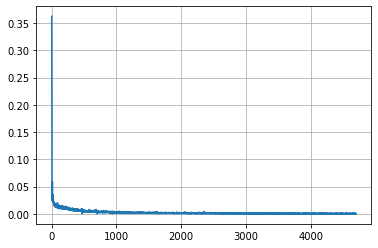

In [18]:
import matplotlib.pyplot as plt

plt.grid()
plt.plot(range(len(losses)), losses)

## Evaluating the model

In [51]:
import numpy as np
import sklearn.metrics as mt

def evaluate_model(model, X, Y, device):
  model.eval()

  predictions = None
  truths = None

  with torch.no_grad():

    # recover labels from one-hot encoding
    truths = Y.argmax(dim=2)

    # recover labels from probabilities
    preds = model(X.to(device))
    predictions = preds.argmax(dim=2)

    # flatten labels
    truths = truths.reshape(-1).cpu().numpy()

    predictions = predictions.reshape(-1).cpu().numpy()

    return mt.accuracy_score(truths, predictions), mt.f1_score(truths, predictions, average='macro'), preds

In [52]:
acc, f1, preds_prob = evaluate_model(model, X_test, Y_test, device)
print(f'Accuracy: {acc*100}, f1: {f1*100}')

Accuracy: 99.34365140995773, f1: 77.89567514339262


## CoNLL evaluation

In [48]:
preds = preds_prob.argmax(dim=2).cpu().numpy()
preds_unpadded, truncated_truths = unpad(preds, test_set)

results = conll.evaluate(truncated_truths, format_predictions_for_conll(preds_unpadded, idx2label))
pd_tbl = pd.DataFrame().from_dict(results, orient='index')
pd_tbl.round(decimals=3)

,p,r,f,s
PER,0.747,0.619,0.677,1616
MISC,0.551,0.714,0.622,702
ORG,0.778,0.656,0.712,1661
LOC,0.875,0.803,0.837,1667
total,0.759,0.696,0.726,5646
